# An Application of Gaussian Mixture Regression for the Correction of Low Cost $PM_{2.5}$ Monitoring Data in Accra, Ghana
## Hourly Analysis
*Celeste McFarlane, Garima Raheja, Carl Malings, Emmanuel K. Appoh, Alison Felix Hughes, Daniel Westervelt*


In [1]:
# import required packages
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors as mpc
from sklearn.mixture import GaussianMixture
import pandas as pd
import math
import seaborn as sns; sns.set()
from sklearn.metrics import r2_score 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from gmr import GMM

from IPython.display import clear_output

%load_ext autoreload
%autoreload 
%matplotlib inline

In [2]:
# import data
# INSERT PATH TO FILE HERE
path_h = "C:/Users/cmcfa/OneDrive/Desktop/2020 Research/Accra/Full Time Series Scripts/hourlyPA_embassy.csv"
data_h = pd.read_csv(path_h, header = 0, index_col = 0)

# subset just to get columns for model
model_data_h = data_h[["purpleair_pm2.5", "avg_temp", "RH", "embassy_pm2.5"]]

In [3]:
# define functions for model evaluation
def n_bias(estimated, true):
    estimated_ = estimated.reshape(estimated.shape[0])
    
    true_ = true.reshape(true.shape[0])
    return np.sum(np.subtract(estimated_, true_))/estimated_.shape[0]

def cvMAE(estimated, true):
    estimated_ = estimated.reshape(estimated.shape[0])
    true_ = true.reshape(true.shape[0])
    return np.sum(abs(np.subtract(estimated_, true_) - n_bias(estimated_, true)))/np.sum(true_)

def mnbias(estimated, true):
    estimated_ = estimated.reshape(estimated.shape[0])
    true_ = true.reshape(true.shape[0])
    return np.sum(np.subtract(estimated_, true_))/np.sum(true_)

def nmae(estimated, true):
    estimated_ = estimated.reshape(estimated.shape[0])
    true_ = true.reshape(true.shape[0])
    return np.sum(np.abs(np.subtract(estimated_, true_)))/np.sum(true_)

## Build Model With 80:20 Training:Testing Data Split

### Model Selection via Bayesian Information Criterion

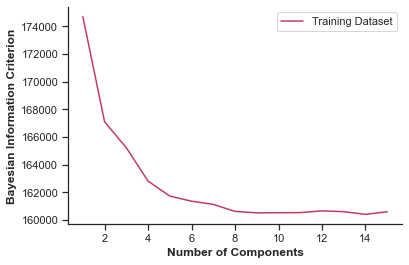

In [4]:
# generate training and testing data splits
train_h, test_h = train_test_split(model_data_h, test_size = 0.2, random_state = 13)

# select models with lowest BIC
n_components = np.arange(1, 16)
models_train = [GaussianMixture(n, covariance_type = 'full', random_state = 2).fit(train_h) for n in n_components]

sns.set_style("ticks", {"xtick.major.size": 7, "ytick.major.size": 7})

plt.plot(n_components, [m.bic(train_h) for m in models_train], color = "#C33969", label = 'Training Dataset')
plt.legend(loc = 'upper right')
plt.xlabel('Number of Components', fontweight = 'bold')
plt.ylabel('Bayesian Information Criterion', fontweight = 'bold')

sns.despine()

plt.show()

In [6]:
gmm_h = GMM(n_components = 8, random_state = 11)
gmm_h.from_samples(train_h.to_numpy())

Y_h = gmm_h.predict(np.array([0,1,2]), test_h[["purpleair_pm2.5", "avg_temp", "RH"]].to_numpy())

print(r2_score(Y_h, test_h[["embassy_pm2.5"]].to_numpy()))
print(mean_absolute_error(Y_h, test_h[["embassy_pm2.5"]].to_numpy()))
print(n_bias(Y_h, test_h[["embassy_pm2.5"]].to_numpy()))
print(cvMAE(Y_h, test_h[["embassy_pm2.5"]].to_numpy()))
print(mnbias(Y_h, test_h[["embassy_pm2.5"]].to_numpy()))
print(nmae(Y_h, test_h[["embassy_pm2.5"]].to_numpy()))

0.7576008985854212
4.136912735720333
-0.24279327730376613
0.1649208802738954
-0.00961128670731657
0.16376505489652082


### Cross Validation

We will now perform a 10 fold cross validation within the training data. We will find the minimum of the BIC for each fold, build a GMM, and then perform a regression

In [7]:
kf = KFold(n_splits = 10, random_state = 8, shuffle = True)

n_components = np.arange(1, 11)

CVs = []

training_data = []

for train_index, test_index in kf.split(train_h):
    train, test = train_h.to_numpy()[train_index], train_h.to_numpy()[test_index]
    
    n = 8
    
    #GMR
    gmm_ = GMM(n_components = n, random_state = 11)
    gmm_.from_samples(train)
    Y_ = gmm_.predict(np.array([0,1,2]), test[:, [0,1,2]])
                     
    r2 = r2_score(Y_, test[:, [3]])
    mae = mean_absolute_error(Y_, test[:, [3]])
    bias_gmr = n_bias(Y_, test[:,3])
    cvMAE_gmr = cvMAE(Y_, test[:,3])
    mnbias_gmr = mnbias(Y_, test[:,3])
    nmae_gmr = nmae(Y_, test[:,3])
    
    #MLR
    regr = linear_model.LinearRegression()
    regr.fit(train[:,[0,1,2]], train[:,[3]])
    mlr_pred = regr.predict(test[:,[0,1,2]])
    
    mlr_r2 = r2_score(test[:,3], mlr_pred)
    mlr_mae = mean_absolute_error(test[:,3], mlr_pred)
    bias_mlr = n_bias(mlr_pred,test[:,3])
    cvMAE_mlr = cvMAE(mlr_pred, test[:,3])
    mnbias_mlr = mnbias(mlr_pred, test[:,3])
    nmae_mlr = nmae(mlr_pred, test[:,3])
        
    #Random Forest
    RF_regr = RandomForestRegressor(max_features = 1, random_state = 0)
    RF_regr.fit(train[:,[0,1,2]], train[:,[3]])
    RF_pred = RF_regr.predict(test[:,[0,1,2]])
    
    RF_r2 = r2_score(test[:,3], RF_pred)
    RF_mae = mean_absolute_error(test[:,3], RF_pred)
    bias_RF = n_bias(RF_pred, test[:,3])
    cvMAE_RF = cvMAE(RF_pred, test[:,3])
    mnbias_RF = mnbias(RF_pred, test[:,3])
    nmae_RF = nmae(RF_pred, test[:,3])
                   
    row = np.array([r2, mlr_r2, RF_r2, 
                    mae, mlr_mae, RF_mae,
                    nmae_gmr, nmae_mlr, nmae_RF,
                    cvMAE_gmr, cvMAE_mlr, cvMAE_RF,
                    bias_gmr, bias_mlr, bias_RF,
                    mnbias_gmr, mnbias_mlr, mnbias_RF])
    CVs.append(row)

CVs = pd.DataFrame(CVs, columns = ['GMR R2', 'MLR R2', 'RF R2',
                                   'GMR MAE', 'MLR MAE', 'RF MAE',
                                  'GMR nMAE', 'MLR nMAE', 'RF nMAE',
                                  'GMR cvMAE', 'MLR cvMAE', 'RF cvMAE',
                                  'GMR Bias', 'MLR Bias', 'RF Bias',
                                  'GMR mnBias', 'MLR mnBias', 'RF mnBias'])

In [8]:
CVs

,GMR R2,MLR R2,RF R2,GMR MAE,MLR MAE,RF MAE,GMR nMAE,MLR nMAE,RF nMAE,GMR cvMAE,MLR cvMAE,RF cvMAE,GMR Bias,MLR Bias,RF Bias,GMR mnBias,MLR mnBias,RF mnBias
0,0.780633,0.742420,0.727646,3.946637,4.438719,4.128082,0.160276,0.180260,0.167644,0.159767,0.180383,0.169409,0.108338,-0.026027,-0.350244,0.004400,-0.001057,-0.014224
1,0.704466,0.619090,0.783646,4.288418,5.039847,4.468371,0.172419,0.202630,0.179654,0.172443,0.204447,0.179248,-0.003412,-0.269339,0.066210,-0.000137,-0.010829,0.002662
2,0.660764,0.744299,0.768464,3.740364,4.246531,3.948843,0.149770,0.170037,0.158117,0.150502,0.169882,0.158703,-0.246906,0.040511,-0.242390,-0.009886,0.001622,-0.009706
3,0.804988,0.788287,0.810798,3.841505,4.378033,3.906195,0.159375,0.181635,0.162059,0.158409,0.179757,0.160363,0.292031,0.569016,0.332253,0.012116,0.023607,0.013784
4,0.649269,0.629398,0.791738,4.284543,5.037121,4.304947,0.167317,0.196706,0.168114,0.168088,0.198650,0.168476,-0.125808,-0.288094,-0.069939,-0.004913,-0.011250,-0.002731
5,0.649158,0.682369,0.726254,4.413161,5.031743,4.534429,0.173153,0.197423,0.177911,0.173760,0.197259,0.178930,-0.090909,0.029544,-0.137900,-0.003567,0.001159,-0.005411
6,0.775698,0.715695,0.824508,4.369453,4.834938,4.284810,0.174661,0.193268,0.171278,0.172947,0.192462,0.170202,0.419499,0.179155,0.264566,0.016769,0.007161,0.010576
7,0.733333,0.734988,0.753833,4.086275,4.648985,4.159055,0.165684,0.188500,0.168635,0.164585,0.187034,0.168651,0.231299,0.386331,-0.005549,0.009378,0.015664,-0.000225
8,0.738012,0.755563,0.779416,3.979185,4.519452,4.205381,0.155341,0.176432,0.164171,0.155611,0.176872,0.165200,-0.373508,-0.158623,-0.468369,-0.014581,-0.006192,-0.018284
9,0.707145,0.670499,0.809074,4.532837,5.070728,4.241189,0.175472,0.196294,0.164182,0.175753,0.197969,0.165527,-0.076466,-0.449154,-0.327348,-0.002960,-0.017387,-0.012672


## Model Comparison

### Multiple Linear Regression

In [9]:
# Create linear regression object
regr_h = linear_model.LinearRegression()

# Train the model using the training sets
regr_h.fit(train_h[["purpleair_pm2.5", "avg_temp", "RH"]], train_h[["embassy_pm2.5"]])

mlr_pred_h = regr_h.predict(test_h[["purpleair_pm2.5", "avg_temp", "RH"]]).reshape(test_h.shape[0])

print(r2_score(test_h[["embassy_pm2.5"]], mlr_pred_h))
print(mean_absolute_error(test_h[["embassy_pm2.5"]], mlr_pred_h))
print(n_bias(mlr_pred_h, test_h[["embassy_pm2.5"]].to_numpy()))
print(cvMAE(mlr_pred_h, test_h[["embassy_pm2.5"]].to_numpy()))
print(mnbias(mlr_pred_h, test_h[["embassy_pm2.5"]].to_numpy()))
print(nmae(mlr_pred_h, test_h[["embassy_pm2.5"]].to_numpy()))

0.7332640382598803
4.699392865443719
-0.16678494718813303
0.18658662871665996
-0.0066023984011889005
0.18603156018849507


### Random Forest

In [10]:
RF_regr_h = RandomForestRegressor(max_features = 1, random_state = 0)
RF_regr_h.fit(train_h[["purpleair_pm2.5", "avg_temp", "RH"]], train_h[["embassy_pm2.5"]])

RF_pred_h = RF_regr_h.predict(test_h[["purpleair_pm2.5", "avg_temp", "RH"]])

print(r2_score(test_h[["embassy_pm2.5"]], RF_pred_h))
print(mean_absolute_error(test_h[["embassy_pm2.5"]], RF_pred_h))
print(n_bias(RF_pred_h, test_h[["embassy_pm2.5"]].to_numpy()))
print(cvMAE(RF_pred_h, test_h[["embassy_pm2.5"]].to_numpy()))
print(mnbias(RF_pred_h, test_h[["embassy_pm2.5"]].to_numpy()))
print(nmae(RF_pred_h, test_h[["embassy_pm2.5"]].to_numpy()))

0.8001335405790052
4.2394457978075515
-0.26437880633373934
0.16902470701241804
-0.010465777863497191
0.16782395911183973
